In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce

In [130]:
def read_cred():
    f = open("../../../cred.txt", "r")
    cred = f.read()
    f.close()
    return cred

In [131]:
def get_OI(url,start,end,interval='PT1M',tag='xx',auth='xx',hS='00',hF='23'):
	url_all =url+'data-reference='+tag+'&aggregation=TIME'+'&aggregation-function=MEAN'+"&from="+start+"T"+hS+"%3A00%3A00.000Z&to="+end+"T"+hF+"%3A59%3A59.000Z&aggregation-period="+interval
	d_data = pd.read_json(url_all,storage_options={ 'Authorization': 'basic '+auth})
	# print(d_data['values'][0])
	arr = np.asarray(np.asarray(d_data['values'])[0])
	return d_data['values'][0]

In [132]:
urlBase = 'https://oianalytics-100.optimistik.fr/api/oianalytics/time-values/query?'
credentials = read_cred()

In [314]:
def get_data(tags):
    liste = list(range(0))
    for tag in tags:
        data = get_OI(urlBase,'2021-07-01','2022-01-31','PT20M',tag,credentials,'00','23')
        df = pd.DataFrame(data)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp')
        df = df.rename(columns={'value':tag})
        liste.append(df)
    return liste

In [315]:
def merge_data(liste):
    df = reduce(lambda left,right : pd.merge(left, right,left_index=True,right_index=True,how='outer'),liste)
    return df

In [359]:
tags = ['E-T15223','E-T18223','3B-T99994','E-FC16325','E-FCS14325','E-FCS12085','E-FS31053','E-FQ41504','E-QUR-E2']
#tags = ['E-T15223','E-T18223','E-FCS14325','E-FC16325','E-FCS12085','E-LS18603','E-LC18604','E-LS15603','E-LC15604','E-FS31053','E-PD15010','E-PD18010','3B-T99994','E-QUR-E2','ROC_E2_Prod_MMP_brut','E-FQ41504','E-TC18202','E-TC15202']
df_list = get_data(tags)
data = merge_data(df_list)
result = data.copy()
result.describe()

,E-T15223,E-T18223,3B-T99994,E-FC16325,E-FCS14325,E-FCS12085,E-FS31053,E-FQ41504,E-QUR-E2
count,15477.000000,15477.000000,15431.000000,15477.000000,15477.000000,15477.000000,15477.000000,15477.000000,1.547700e+04
mean,389.804087,382.536342,14.361513,8046.045421,4256.441424,45413.754243,9822.273131,15906.140188,6.235928e+02
std,22.538717,20.687768,8.508218,2469.877058,1184.444237,12940.814955,2821.369975,4956.890090,3.302491e+05
min,268.276000,247.917750,-3.491465,-0.075176,14.089720,3.949767,12.239705,-26.876130,-3.534675e+07
25%,388.287400,381.918900,6.902344,7447.013000,3818.675500,43995.870000,9986.649000,14878.360000,5.161899e+02
50%,396.603900,387.284200,14.367705,9345.362500,4686.648500,51500.850000,10497.800000,18523.380000,5.207433e+02
75%,400.826550,392.212750,20.907160,9590.683500,4784.712500,52499.325000,11020.430000,19001.255000,5.257549e+02
max,423.423450,414.827000,37.633960,10076.175000,7537.602500,52554.240000,12871.715000,22686.530000,1.995554e+07


## Filtre

In [358]:
def filtering(df):
    df = df[(df['E-QUR-E2']>500) & (df['E-QUR-E2']<600)]
    df = df[df['E-T15223']>390]
    df = df[df['E-FC16325']>9000]
    df = df[df['E-FCS12085']>52400]
    return df

In [360]:
result = filtering(result)
result.describe()

,E-T15223,E-T18223,3B-T99994,E-FC16325,E-FCS14325,E-FCS12085,E-FS31053,E-FQ41504,E-QUR-E2
count,6953.000000,6953.000000,6907.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000
mean,399.380534,388.508463,15.745557,9596.387108,4899.641212,52499.918337,10235.964997,18994.634562,521.577561
std,4.269080,3.943194,8.114820,53.372143,251.166420,13.785763,424.643594,203.855890,6.073370
min,390.021700,379.029900,-1.309197,9046.789500,4201.492000,52400.735000,9118.181000,17887.955000,500.148650
25%,396.509350,385.786650,8.430613,9570.465500,4728.212000,52491.030000,9907.899000,18870.250000,517.755300
50%,399.255700,388.205850,16.624010,9593.218000,4766.931500,52500.035000,10245.115000,19012.520000,521.281450
75%,401.883350,391.549500,22.018265,9619.180500,5183.257500,52509.060000,10551.755000,19140.865000,524.673750
max,414.160700,402.746700,37.123310,10076.175000,5714.991500,52554.240000,11204.220000,19984.880000,558.168200


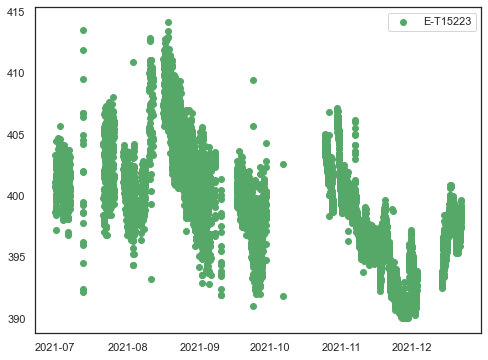

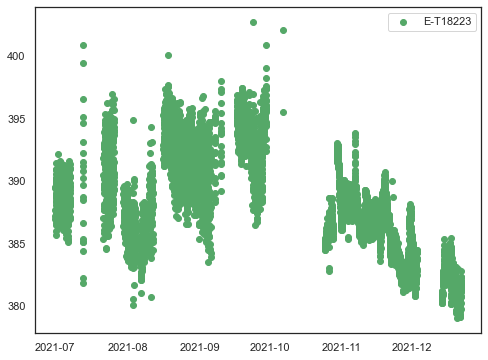

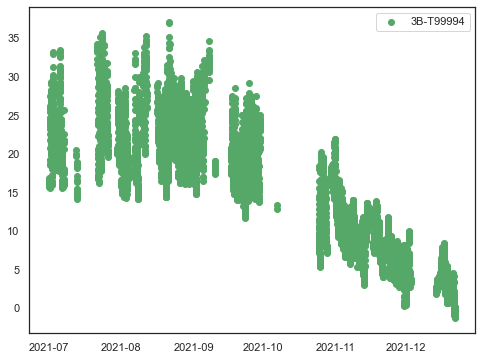

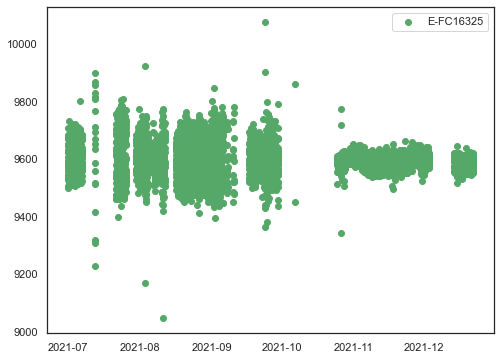

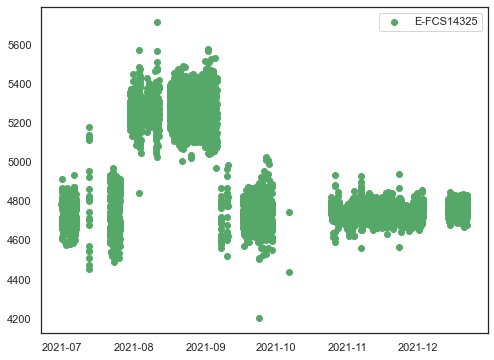

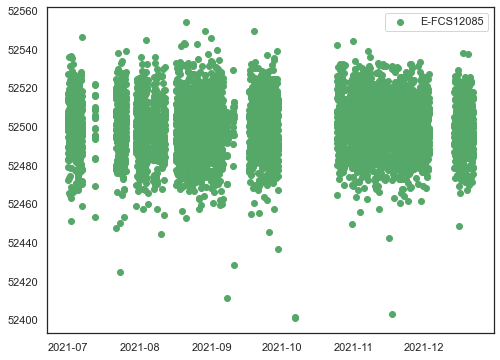

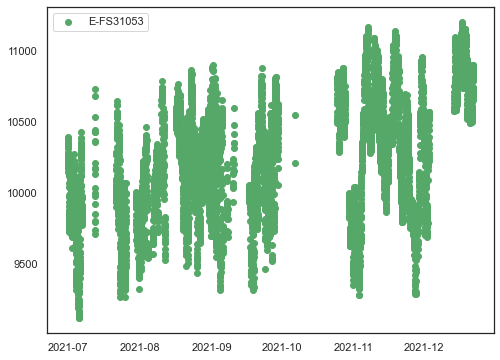

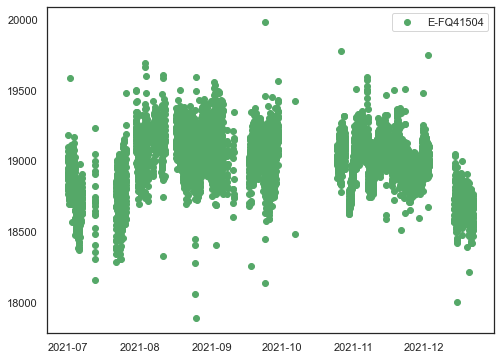

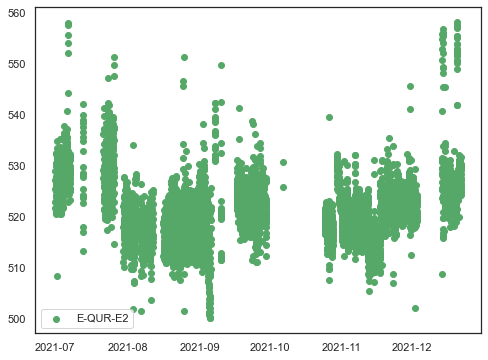

In [362]:
for tag in tags:
    plt.figure(figsize=(8,6))
# plt.plot(result[tags[0]],label=tags[0])
    plt.scatter(result.index ,result[tag],label=tag, c='g')
    plt.legend()

In [320]:
def get_perf(row):
    crit = 'E-QUR-E2'
    if row['E-QUR-E2'] > 540:
        ret=10
    elif row['E-QUR-E2']>535:
        ret=9
    elif row['E-QUR-E2']>530:
        ret=8
    elif row['E-QUR-E2']>525:
        ret=7
    elif row['E-QUR-E2']>520:
        ret=6
    elif row['E-QUR-E2']>515:
        ret=5
    elif row['E-QUR-E2']>510:
        ret=4
    elif row['E-QUR-E2']>505:
        ret=3
    elif row['E-QUR-E2']>500:
        ret=2
    elif row['E-QUR-E2']>495:
        ret=1
    else:
        ret =0
    return ret   

In [363]:
result['perf'] = result.apply(get_perf,axis=1)
result = result.drop('E-QUR-E2',axis=1)
result.describe()

,E-T15223,E-T18223,3B-T99994,E-FC16325,E-FCS14325,E-FCS12085,E-FS31053,E-FQ41504,perf
count,6953.000000,6953.000000,6907.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000
mean,399.380534,388.508463,15.745557,9596.387108,4899.641212,52499.918337,10235.964997,18994.634562,5.802963
std,4.269080,3.943194,8.114820,53.372143,251.166420,13.785763,424.643594,203.855890,1.184022
min,390.021700,379.029900,-1.309197,9046.789500,4201.492000,52400.735000,9118.181000,17887.955000,2.000000
25%,396.509350,385.786650,8.430613,9570.465500,4728.212000,52491.030000,9907.899000,18870.250000,5.000000
50%,399.255700,388.205850,16.624010,9593.218000,4766.931500,52500.035000,10245.115000,19012.520000,6.000000
75%,401.883350,391.549500,22.018265,9619.180500,5183.257500,52509.060000,10551.755000,19140.865000,6.000000
max,414.160700,402.746700,37.123310,10076.175000,5714.991500,52554.240000,11204.220000,19984.880000,10.000000


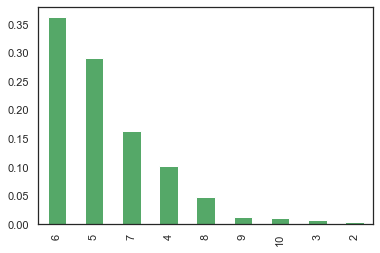

In [364]:
freq = (result.perf.value_counts()/result.shape[0]).plot.bar(color='g')

<AxesSubplot:xlabel='E-FC16325', ylabel='Count'>

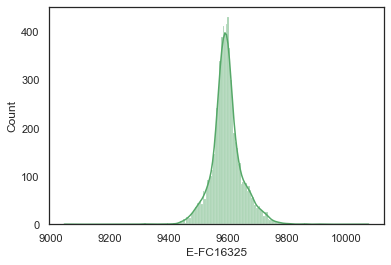

In [367]:
sns.color_palette("tab10")
sns.color_palette("rocket", as_cmap=True)
couleur = ['b','g','r','y','g']
sns.histplot(result['E-FC16325'],kde=True , color='g')

<AxesSubplot:>

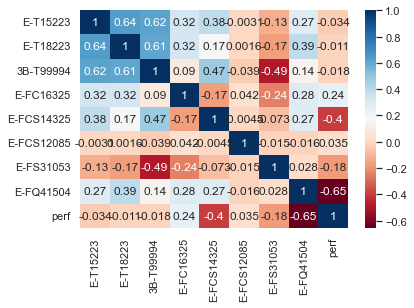

In [368]:
sns.color_palette("tab10")
sns.heatmap(result.corr(),annot=True, cmap='RdBu')

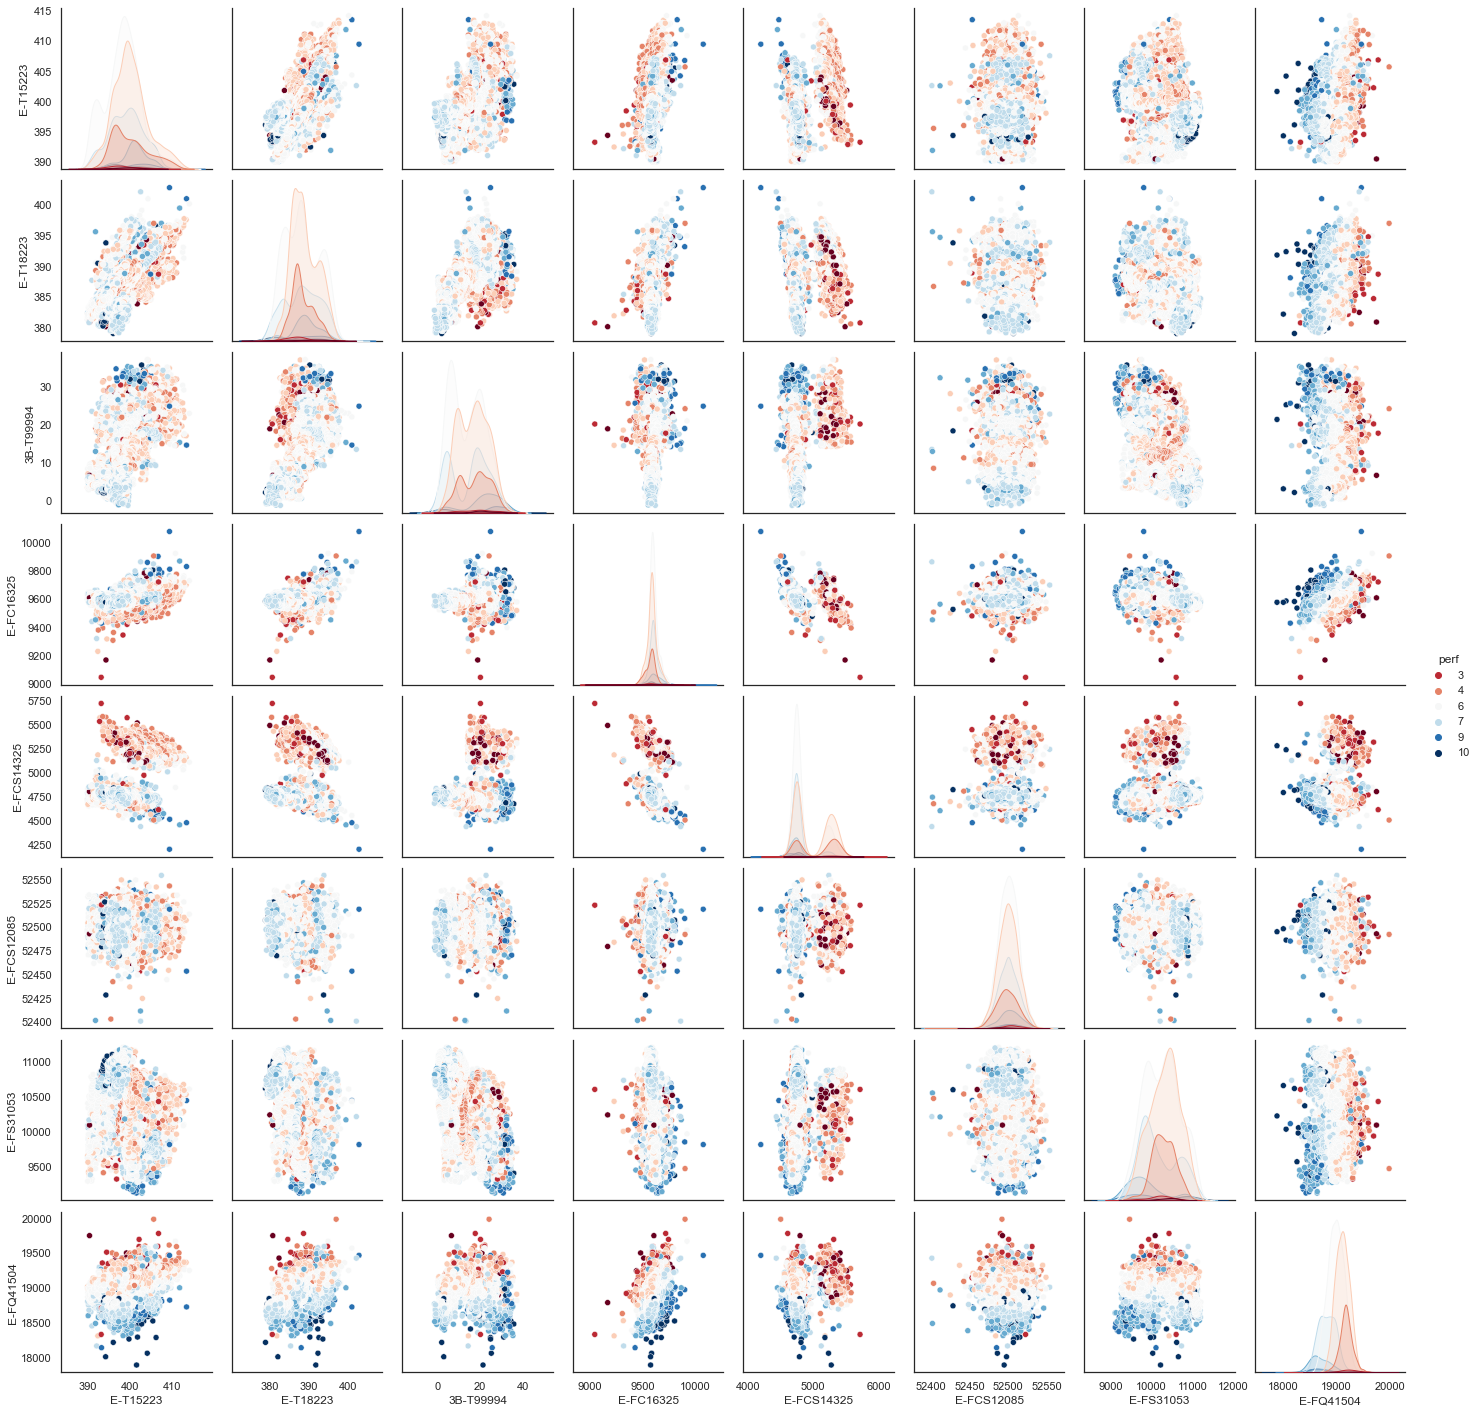

In [369]:
# sns.set_theme(style="ticks")
sns.set_theme(style='white',palette='Blues')
sns.color_palette("tab10")
sns.pairplot(data=result, hue='perf',palette='RdBu') 